<img src='https://unlearning-challenge.github.io/Unlearning-logo.png' width='100px'>

# NeurIPS 2023 Machine Unlearning Challenge Starting Kit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/unlearning-challenge/starting-kit/main/unlearning-CIFAR10.ipynb)


This notebook is part of the starting kit for the [NeurIPS 2023 Machine Unlearning Challenge](https://unlearning-challenge.github.io/). This notebook explains the pipeline of the challenge and contains sample unlearning and evaluation code.


This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).

  * 🎯 In the second section we'll develop the unlearning algorithm. We start by splitting the original training set into a retain set and a forget set. The goal of an unlearning algorithm is to update the pre-trained model so that it approximates as much as possible a model that has been trained on the retain set but not on the forget set. We provide a simple unlearning algorithm as a starting point for participants to develop their own unlearning algorithms.

  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA). Note that this is a different evaluation than the one that will be used in the competition's submission.
  

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [9]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [10]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# for the unlearning algorithm we'll also need a split of the train set into
# forget_set and a retain_set
forget_set, retain_set = torch.utils.data.random_split(train_set, [0.1, 0.9], generator=RNG)
forget_loader = torch.utils.data.DataLoader(forget_set, batch_size=128, shuffle=True, num_workers=2,generator=RNG)
retain_loader = torch.utils.data.DataLoader(retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG)

Files already downloaded and verified
Files already downloaded and verified


#  Label smoothing

In this code snippet, we define a custom PyTorch Dataset class, SmoothUnLearningData, designed specifically for the unlearning process with label smoothing.  

In [11]:

class SmoothUnLearningData(Dataset):
    def __init__(self, forget_data, retain_data, num_classes, epsilon):
        self.forget_data = forget_data
        self.retain_data = retain_data
        self.forget_len = len(forget_data)
        self.retain_len = len(retain_data)
        self.num_classes = num_classes
        self.epsilon = epsilon

    def __len__(self):
        return self.forget_len + self.retain_len

    def __getitem__(self, index):
        if(index < self.forget_len):
            x, y = self.forget_data[index]
            if isinstance(y, torch.Tensor):
                y = torch.argmax(y)  # Convert one-hot vector to class index
            assert 0 <= y < self.num_classes, f"Invalid class index: {y}"
            y = self.smooth_labels(y)  # Class index for forget data
            return x, y
        else:
            x, y = self.retain_data[index - self.forget_len]
            if isinstance(y, torch.Tensor):
                y = torch.argmax(y)  # Convert one-hot vector to class index
            assert 0 <= y < self.num_classes, f"Invalid class index: {y}"
            y = self.one_hot_labels(y)  # One-hot encoded labels for retain data
            return x, y

    def smooth_labels(self, target):
        smooth_label = torch.ones(self.num_classes).float() * self.epsilon / (self.num_classes - 1)
        smooth_label[target] = 1. - self.epsilon
        return smooth_label

    def one_hot_labels(self, target):
        one_hot = torch.zeros(self.num_classes).float()
        one_hot[target] = 1.0
        return one_hot



# Usage:
num_classes = 10  # CIFAR-10 has 10 classes
smoothing = 0.1

# Create the smoothed dataset
smoothed_forget_dataset = SmoothUnLearningData(forget_set, retain_set, num_classes, smoothing)

# Create the DataLoaders
data_loader = torch.utils.data.DataLoader(smoothed_forget_dataset, batch_size=256, shuffle=True, num_workers=1)

In [12]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://unlearning-challenge.s3.eu-west-1.amazonaws.com/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

Let us show some of the training images, just for fun.

Files already downloaded and verified


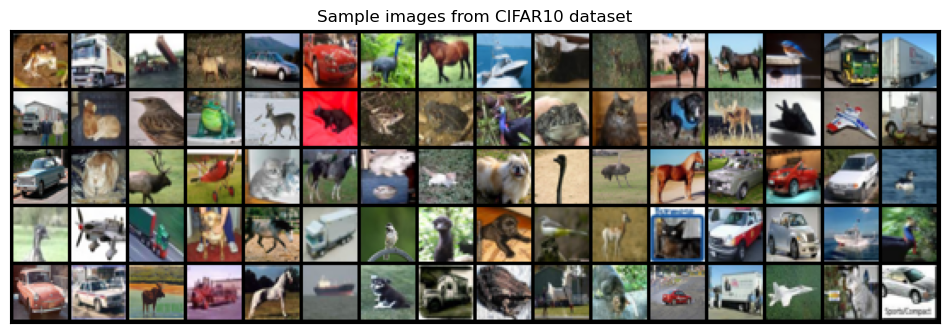

In [13]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

We'll now compute the model's accuracy on the train and test set.


In [14]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


# 🎯 Unlearning Algorithm

In this section we develop the unlearning algorithm.

In the previous section we created a split of the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm _unlearning by fine-tuning_. It starts from the pre-trained model and optimizes it for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient, and we don't expect it to work very well for most metrics.

To make a new entry in the competition, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).

# My Unlearning Algorithm

In this section, we define the unlearning loss function and the unlearning step. The unlearning loss function, UnlearnerLoss, computes the Kullback-Leibler (KL) divergence between the output of the student model and the teacher models. The unlearning step, unlearning_step, performs a single step of unlearning by computing the loss and updating the model parameters. We then define blindspot_unlearner function which iterates the unlearning step over multiple epochs. 

In [15]:
# Define the unlearning loss function
def UnlearnerLoss(output, labels, full_teacher_logits, unlearn_teacher_logits, KL_temperature):
    """
    Compute the loss for the unlearning process.

    Parameters:
    output (torch.Tensor): The output from the student model.
    labels (torch.Tensor): The true labels for the data.
    full_teacher_logits (torch.Tensor): The output logits from the fully trained teacher model.
    unlearn_teacher_logits (torch.Tensor): The output logits from the unlearning teacher model.
    KL_temperature (float): The temperature parameter for the softmax function.

    Returns:
    torch.Tensor: The computed loss.
    """
    # Expand the dimensions of the labels tensor
    labels = torch.unsqueeze(labels, dim = 1)
    
    # Compute the softmax outputs for the teacher models
    full_teacher_softmax_output = F.softmax(full_teacher_logits / KL_temperature, dim=1)
    unlearn_teacher_softmax_output = F.softmax(unlearn_teacher_logits / KL_temperature, dim=1)

    # Combine the teacher outputs based on the labels
    combined_teacher_output = labels * unlearn_teacher_softmax_output + (1-labels)*full_teacher_softmax_output

    # Compute the log softmax output for the student model
    student_log_softmax_output = F.log_softmax(output / KL_temperature, dim=1)

    # Compute and return the KL divergence loss
    return F.kl_div(student_log_softmax_output, combined_teacher_output)

# Define the unlearning step
def unlearning_step(model, unlearning_teacher, full_trained_teacher, unlearn_data_loader, optimizer, 
            device, KL_temperature):
    losses = []
    for batch in unlearn_data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            full_teacher_logits = full_trained_teacher(x)
            unlearn_teacher_logits = unlearning_teacher(x)
        output = model(x)
        optimizer.zero_grad()
        loss = UnlearnerLoss(output = output, labels=y, full_teacher_logits=full_teacher_logits, 
                unlearn_teacher_logits=unlearn_teacher_logits, KL_temperature=KL_temperature)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    return np.mean(losses)

def blindspot_unlearner(model, unlearning_teacher, full_trained_teacher, retain_data, forget_data, epochs, optimizer, batch_size, num_workers, device, KL_temperature):
    print("Entered blindspot_unlearner function.")
    """
    Perform the unlearning process using the blindspot method.

    Parameters:
    model (torch.nn.Module): The model to be unlearned.
    unlearning_teacher (torch.nn.Module): The teacher model for the unlearning process.
    full_trained_teacher (torch.nn.Module): The fully trained teacher model.
    retain_data (torch.utils.data.Dataset): The dataset to be retained.
    forget_data (torch.utils.data.Dataset): The dataset to be forgotten.
    epochs (int): The number of epochs for the unlearning process.
    optimizer (torch.optim.Optimizer): The optimizer for the unlearning process.
    batch_size (int): The batch size for the data loaders.
    num_workers (int): The number of workers for the data loaders.
    device (torch.device): The device to run the computations on.
    KL_temperature (float): The temperature parameter for the softmax function.

    Returns:
    torch.nn.Module: The unlearned model.
    """
    # Add the error handling code here
    if not isinstance(retain_data, torch.utils.data.Dataset) or not isinstance(forget_data, torch.utils.data.Dataset):
        raise TypeError("retain_data and forget_data must be instances of torch.utils.data.Dataset")

    if len(retain_data) == 0 or len(forget_data) == 0:
        raise ValueError("retain_data and forget_data must not be empty")

    # creating the unlearning dataset.
    unlearning_data = SmoothUnLearningData(forget_data=forget_data, retain_data=retain_data, num_classes=10, epsilon=0.1)
    unlearning_loader = DataLoader(unlearning_data, batch_size = batch_size, shuffle=True, 
                        num_workers=num_workers, pin_memory=True)

    unlearning_teacher.eval()
    full_trained_teacher.eval()
    model.train()

    if optimizer is None:
        raise ValueError("No optimizer provided.")
   # if optimizer is not a valid string, then assuming it as a function to return optimizer
    for epoch in range(epochs):
        loss = unlearning_step(model = model, unlearning_teacher= unlearning_teacher, 
                        full_trained_teacher=full_trained_teacher, unlearn_data_loader=unlearning_loader, 
                        optimizer=optimizer, device=device, KL_temperature=KL_temperature)
        print("Epoch {} Unlearning Loss {}".format(epoch+1, loss))

    return ft_model

Finally, we create instances of our model, the unlearning teacher, and the fully trained teacher, and perform the unlearning process using the blindspot_unlearner function.

In [16]:
class MyModel(nn.Module):
    def __init__(self, pretrained_weights):
        super(MyModel, self).__init__()
        self.resnet = resnet18(weights=None, num_classes=10)
        self.resnet.load_state_dict(pretrained_weights)  # Load the pre-trained weights here
        self.dropout = nn.Dropout(p=0.55)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x

# Load the pre-trained model
ft_model = MyModel(weights_pretrained)
ft_model.to(DEVICE)

# Define the unlearning teacher without pre-trained weights
unlearning_teacher = resnet18(weights=None, num_classes=10)
unlearning_teacher.to(DEVICE)


# Define the fully trained teacher
full_trained_teacher = MyModel(weights_pretrained)
full_trained_teacher.to(DEVICE)

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

# Unlearn
ft_model = blindspot_unlearner(ft_model, unlearning_teacher, full_trained_teacher, retain_set, smoothed_forget_dataset, epochs = 10,
                optimizer = optimizer, batch_size = 256, num_workers = 0, 
                device = DEVICE, KL_temperature = 1)

ft_model.eval();

Entered blindspot_unlearner function.


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1 Unlearning Loss 0.25736016035079956
Epoch 2 Unlearning Loss 0.2565407156944275
Epoch 3 Unlearning Loss 0.2563493251800537
Epoch 4 Unlearning Loss 0.2570348083972931
Epoch 5 Unlearning Loss 0.2567621171474457
Epoch 6 Unlearning Loss 0.25720205903053284
Epoch 7 Unlearning Loss 0.2565769851207733
Epoch 8 Unlearning Loss 0.2570263147354126
Epoch 9 Unlearning Loss 0.2556275427341461
Epoch 10 Unlearning Loss 0.25784581899642944


In [17]:
#redefine the accuracy for unlearning
def accuracy(net, loader, is_one_hot=False):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, targets = data
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            _, predicted = outputs.max(1)  # Take the argmax here
            if is_one_hot:
                _, targets = targets.max(1)  # Convert one-hot encoded labels to class indices
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

We have now an unlearned model `ft_model`. Besides the forgetting quality (which we'll discuss in the next section), a good unlearning algorithm should retain as much as possible the accuracy on the retain and test set.

To quantify this potential loss of utility, we'll now compute the retain and test accuracies using the unlearned model

In [18]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader, is_one_hot=False):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader, is_one_hot=False):0.1f}%")

Retain set accuracy: 97.9%
Test set accuracy: 86.7%


# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [19]:
def compute_losses(net, loader, num_batches):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for i, (inputs, targets) in enumerate(loader):
        if i >= num_batches:
            break
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).detach().cpu().numpy()  # Modified line
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

num_batches = 10
train_losses = compute_losses(model, train_loader, num_batches)
test_losses = compute_losses(model, test_loader, num_batches)

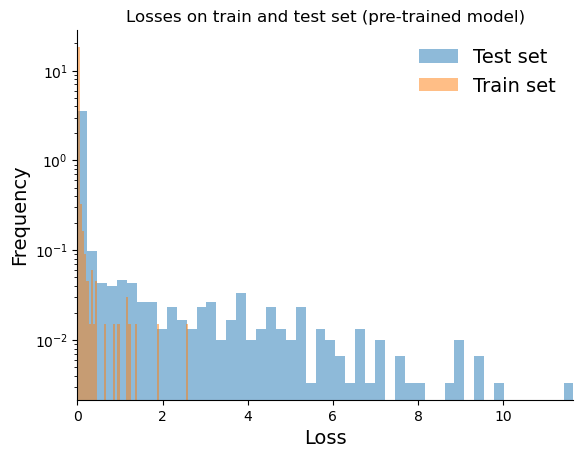

In [20]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set); see the last section of this notebook for additional discussion and for computing that reference point.

In [21]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [22]:
num_batches = 10  # or any other number you want to use

# Compute losses for original model
forget_losses = compute_losses(model, forget_loader, num_batches)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images")


The MIA has an accuracy of 0.576 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [23]:

num_batches = 10
ft_forget_losses = compute_losses(ft_model, forget_loader, num_batches)
ft_test_losses = compute_losses(ft_model, test_loader, num_batches)

# make sure we have a balanced dataset for the MIA
#assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [24]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images")

The MIA has an accuracy of 0.566 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

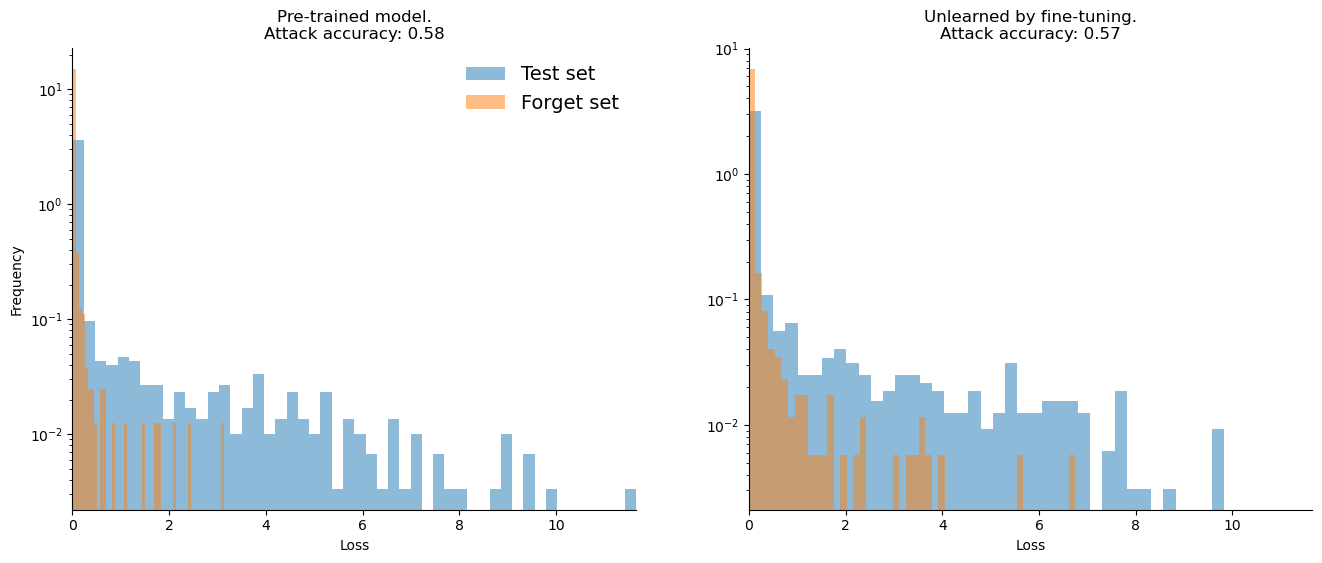

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}")
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [26]:
# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://unlearning-challenge.s3.eu-west-1.amazonaws.com/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval();

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [27]:
rt_test_losses = compute_losses(rt_model, test_loader, num_batches)
rt_forget_losses = compute_losses(rt_model, forget_loader, num_batches)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [28]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images")

The MIA has an accuracy of 0.497 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

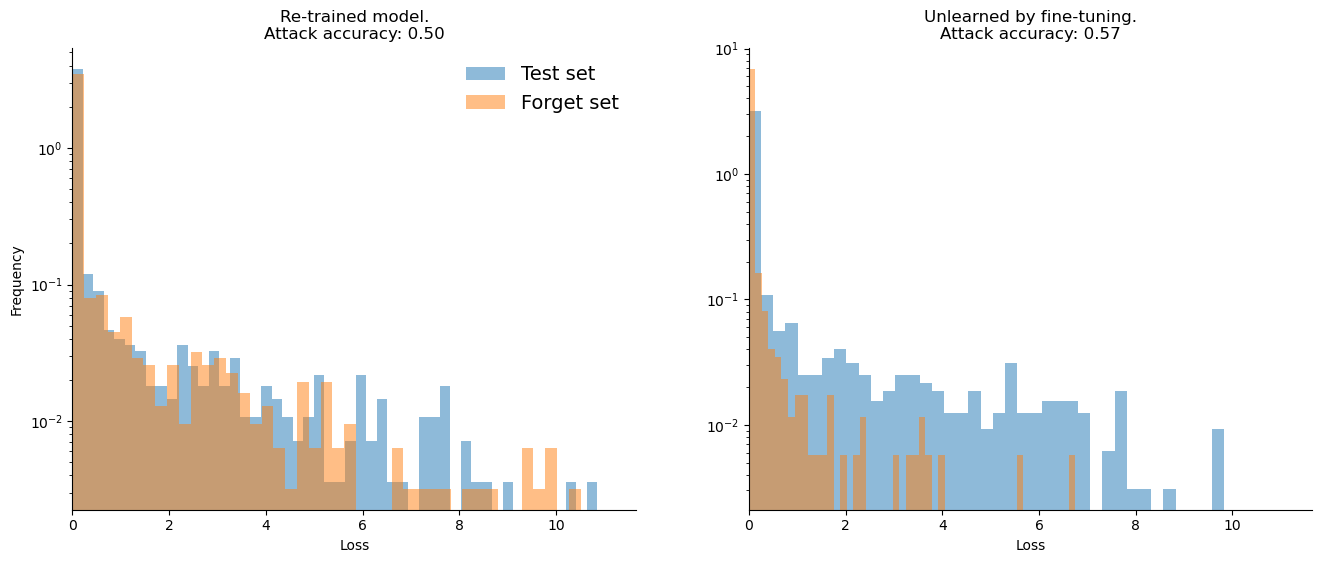

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}")
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

# My Evaluation Process

In this section, we define several functions to perform the AIN (Approximate Inference Negligibility) measurement.

The training_step function performs a single step of training on a batch of data. The evaluate function computes the accuracy of the model on a validation set. The entropy function computes the entropy of a probability distribution. The collect_prob function collects the output probabilities of a model on a dataset.

In [30]:
#train the gold model

# Define your model architecture
gold_model = resnet18(weights=None, num_classes=10)
gold_model.to(DEVICE)

# Your training and validation datasets
train_set = torch.utils.data.ConcatDataset([retain_set, forget_set])  # The retain set and forget set is used for training
valid_set = val_set  # The validation set is used for evaluation


# Define your data loaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=True)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gold_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Train the model
for epoch in range(10):  # replace 10 with the number of epochs you want to train for
    gold_model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = gold_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    gold_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = gold_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        accuracy = correct / total
        print(f'Epoch {epoch+1}, Accuracy: {accuracy*100:.2f}%')

Epoch 1, Accuracy: 39.84%
Epoch 2, Accuracy: 51.60%
Epoch 3, Accuracy: 60.32%
Epoch 4, Accuracy: 63.52%
Epoch 5, Accuracy: 68.76%
Epoch 6, Accuracy: 67.72%
Epoch 7, Accuracy: 70.92%
Epoch 8, Accuracy: 70.24%
Epoch 9, Accuracy: 72.56%
Epoch 10, Accuracy: 72.92%


get_membership_attack_data function prepares the data for the membership inference attack. The MIANet class defines a simple neural network used for the membership inference attack. The get_membership_attack_prob function trains the MIANet on the membership inference attack data and returns the attack success probability.

The relearn_time function measures the time it takes for a model to relearn to a specified accuracy. The ain function performs the AIN measurement by computing the relearning time of the model after forgetting and the gold standard model, and then computing the ratio of these two times.

Finally, we call the ain function to perform the AIN measurement on our models.

In [31]:
# Your model, data loaders, and other parameters
model = ft_model  # The model after forgetting
full_trained_model = resnet18(weights=None, num_classes=10)
full_trained_model.to(DEVICE)  # Move the model to the GPU
full_model = full_trained_model  # The fully trained model
train_set = torch.utils.data.ConcatDataset([retain_set, forget_set])# The retain set and forget set is used for training
train_data = train_set
val_retain = retain_set
val_forget = forget_set
batch_size = 256
error_range = 0.05
lr = 0.001
#the function to evaluate
def training_step(model, batch):
    images, labels = batch 
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return {"Acc": accuracy}


# The function to compute entropy
def entropy(p, dim=-1, keepdim=False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)

# The function to collect probabilities
def collect_prob(data_loader, model):   
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False, num_workers=32, prefetch_factor=10)
    prob = []
    with torch.no_grad():
        for batch in data_loader:
            batch = [tensor.to(DEVICE) for tensor in batch]
            data, _, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

# The function to get membership attack data
def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):    
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)
    
    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])
    
    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])    
    return X_f, Y_f, X_r, Y_r

# Define your neural network for the membership inference attack
class MIANet(nn.Module):
    def __init__(self):
        super(MIANet, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# The function to get membership attack probability
def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    
    # Convert to tensors
    X_r = torch.from_numpy(X_r).float().to(DEVICE)
    Y_r = torch.from_numpy(Y_r).long().to(DEVICE)
    X_f = torch.from_numpy(X_f).float().to(DEVICE)

    # Initialize the neural network for the membership inference attack
    mianet = MIANet().to(DEVICE)
    optimizer = torch.optim.Adam(mianet.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train the neural network
    for epoch in range(10):  # replace 10 with the number of epochs you want to train for
        optimizer.zero_grad()
        outputs = mianet(X_r)
        loss = criterion(outputs, Y_r)
        loss.backward()
        optimizer.step()

    # Use the trained neural network to predict the membership
    with torch.no_grad():
        outputs = mianet(X_f)
        _, predicted = torch.max(outputs.data, 1)
        results = predicted.cpu().numpy()

    return results.mean()

# The function to measure relearning time
def relearn_time(model, train_loader, valid_loader, reqAcc, lr):
    rltime = 0
    curr_Acc = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(10):
        for batch in train_loader:
            model.train()
            loss = training_step(model, batch)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            history = [evaluate(model, valid_loader)]
            curr_Acc = history[0]["Acc"]*100
            print(curr_Acc, sep=',')
            
            rltime += 1
            if(curr_Acc >= reqAcc):
                break
                
        if(curr_Acc >= reqAcc):
            break
    return rltime

# The function to perform the AIN measurement
def ain(full_model, model, gold_model, train_data, val_retain, val_forget, batch_size=256, error_range=0.05, lr=0.001):
    # measuring performance of fully trained model on forget class
     # Error handling
    if not isinstance(full_model, nn.Module) or not isinstance(model, nn.Module) or not isinstance(gold_model, nn.Module):
        raise TypeError("full_model, model, and gold_model must be instances of torch.nn.Module")

    if not isinstance(train_data, torch.utils.data.Dataset) or not isinstance(val_retain, torch.utils.data.Dataset) or not isinstance(val_forget, torch.utils.data.Dataset):
        raise TypeError("train_data, val_retain, and val_forget must be instances of torch.utils.data.Dataset")

    if not isinstance(batch_size, int) or batch_size <= 0:
        raise ValueError("batch_size must be a positive integer")

    if not isinstance(error_range, (int, float)) or error_range <= 0:
        raise ValueError("error_range must be a positive number")

    if not isinstance(lr, (int, float)) or lr <= 0:
        raise ValueError("lr must be a positive number")
    forget_valid_dl = DataLoader(val_forget, batch_size)
    history = [evaluate(full_model, forget_valid_dl)]
    AccForget = history[0]["Acc"]*100
    
    print("Accuracy of fully trained model on forget set is: {}".format(AccForget))
    
    retain_valid_dl = DataLoader(val_retain, batch_size)
    history = [evaluate(full_model, retain_valid_dl)]
    AccRetain = history[0]["Acc"]*100
    
    print("Accuracy of fully trained model on retain set is: {}".format(AccRetain))
    
    history = [evaluate(model, forget_valid_dl)]
    AccForget_Fmodel = history[0]["Acc"]*100
    
    print("Accuracy of forget model on forget set is: {}".format(AccForget_Fmodel))
    
    history = [evaluate(model, retain_valid_dl)]
    AccRetain_Fmodel = history[0]["Acc"]*100
    
    print("Accuracy of forget model on retain set is: {}".format(AccRetain_Fmodel))
    
    history = [evaluate(gold_model, forget_valid_dl)]
    AccForget_Gmodel = history[0]["Acc"]*100
    
    print("Accuracy of gold model on forget set is: {}".format(AccForget_Gmodel))
    
    history = [evaluate(gold_model, retain_valid_dl)]
    AccRetain_Gmodel = history[0]["Acc"]*100
    
    print("Accuracy of gold model on retain set is: {}".format(AccRetain_Gmodel))
    
    reqAccF = (1-error_range)*AccForget
    
    print("Desired Accuracy for retrain time with error range {} is {}".format(error_range, reqAccF))
    
    train_loader = DataLoader(train_data, batch_size, shuffle = True)
    valid_loader = DataLoader(val_forget, batch_size)
    rltime_gold = relearn_time(model = gold_model, train_loader = train_loader, valid_loader = valid_loader, 
                               reqAcc = reqAccF,  lr = lr)
    
    print("Relearning time for Gold Standard Model is {}".format(rltime_gold))
    
    rltime_forget = relearn_time(model = model, train_loader = train_loader, valid_loader = valid_loader, 
                               reqAcc = reqAccF, lr = lr)
    
    print("Relearning time for Forget Model is {}".format(rltime_forget))
    
    rl_coeff = rltime_forget/rltime_gold
    print("AIN = {}".format(rl_coeff))


# Call the function
ain(full_model, model, gold_model, train_data, val_retain, val_forget, batch_size, error_range, lr)


Accuracy of fully trained model on forget set is: 9.4
Accuracy of fully trained model on retain set is: 9.051111111111112
Accuracy of forget model on forget set is: 97.8
Accuracy of forget model on retain set is: 97.92222222222222
Accuracy of gold model on forget set is: 87.16000000000001
Accuracy of gold model on retain set is: 87.25777777777778
Desired Accuracy for retrain time with error range 0.05 is 8.93
85.52
Relearning time for Gold Standard Model is 1
89.68
Relearning time for Forget Model is 1
AIN = 1.0
